# Create Data

Note that all the codes were run on 2 core hyper threaded machine. Tha's why time taken starts to crawl upwards after 4 cores.

In [6]:
%pylab inline
%matplotlib inline
import pandas

Populating the interactive namespace from numpy and matplotlib


Run the following code for 1,2,4 and 8 processors. This will create files `trap_1.out`, `trap_2.out` and so on.
You may need to modify thsi code so it works for your setup.

This cell calls your MPI routine, collects the output, and then "splits" into a list of string data. This data is written to a text file so that you don't have to rerun the code to re-create plots and tables below.  This version assumes your output from your program looks like

    Processor [0] :       1024   1.8725924894828205   1.8725929572658386   4.67783018e-07

In [2]:
file_prefix = 'trap_'

nprocs = 8   # set to 1,2,4, and 8
filename = file_prefix + '{:02d}'.format(nprocs) + '.out'

In [3]:
import subprocess, sys, time

# We write the data to a file so that it doesn't have to be re-run everytime we modify 
# formatting or plotting

f = open(filename,'w')
for pv in range(10,29):
    arg_list = ['/usr/bin/mpirun','-n', str(nprocs), './Vaila_prob2','-p',str(pv)]
        
    # Test to make sure we can run this code
    p = subprocess.run(arg_list,stdout=subprocess.PIPE)    
    if p.returncode > 0:
        print("Something went wrong!")
        sys.exit(0)
    output = p.stdout.decode("utf-8").split()
    
    tr = %timeit -n 1 -r 1 -o pass; p = subprocess.run(arg_list,stdout=subprocess.PIPE)
    
    # Read output
    N = int(output[3])
    soln = float(output[4])
    err = float(output[6])
    
    f.write("{:10d} {:20.16f} {:12.4e} {:12.2e}\n".format(N,soln,err,tr.best))
    
f.close()

531 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
384 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
336 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
375 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
398 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
383 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
338 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
326 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
318 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
373 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
396 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
433 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
573 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
865 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
998 ms ± 0 ns per loop (mean ± std. dev.

We can look at the contents of the text file created above using the magic command `%cat`. 

In [4]:
%cat $filename

      1024   1.8725924894828205   4.6778e-07     5.31e-01
      2048   1.8725928403201064   1.1695e-07     3.84e-01
      4096   1.8725929280294067   2.9236e-08     3.36e-01
      8192   1.8725929499567315   7.3091e-09     3.75e-01
     16384   1.8725929554385621   1.8273e-09     3.98e-01
     32768   1.8725929568090196   4.5682e-10     3.29e-01
     65536   1.8725929571516333   1.1421e-10     3.83e-01
    131072   1.8725929572372864   2.8552e-11     3.38e-01
    262144   1.8725929572587017   7.1372e-12     3.26e-01
    524288   1.8725929572640512   1.7877e-12     3.18e-01
   1048576   1.8725929572654005   4.3832e-13     3.73e-01
   2097152   1.8725929572657205   1.1835e-13     3.96e-01
   4194304   1.8725929572658171   2.1760e-14     4.33e-01
   8388608   1.8725929572658124   2.6423e-14     5.73e-01
  16777216   1.8725929572658566   1.7764e-14     8.65e-01
  33554432   1.8725929572659026   6.3727e-14     9.98e-01
  67108864   1.8725929572658915   5.2625e-14     1.58e+00
 134217728   1

# Accuracy Plots

<hr/>

## Verify the results

We verify the results by making sure that we get the expect error behavior and convergence rates.

Load the results into a Numpy array and create arrays from the columns.

In [23]:
file_prefix = 'trap_'
nprocs = 1   # set to 1,2,4, and 8
filename = file_prefix + '{:02d}'.format(nprocs) + '.out'

In [24]:
# Read text file into numpy array
T = loadtxt(filename)
# Convert slices to column arrays
Nvec = T[:,0].astype('int')
soln = T[:,1]
err  = T[:,2]
t    = T[:,3]

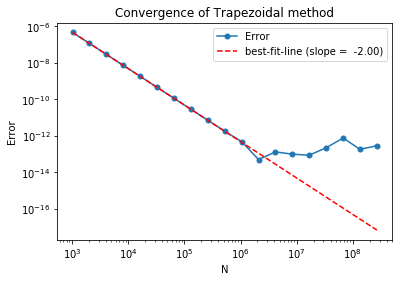

In [25]:
loglog(Nvec,err,'.-',markersize=10)
xlabel('N')
ylabel('Error')
title('Convergence of Trapezoidal method');

c = polyfit(log(Nvec[:-9]),log(err[:-9]),1)
loglog(Nvec,exp(polyval(c,log(Nvec))),'r--')
legend(["Error","best-fit-line (slope = {:6.2f})".format(c[0])])

<hr/>

## Show results in a table

Create and print a Pandas table displaying results. We will add a column containing the convergence rate.

To compute the convergence rate, we assume that the error in our trapezoidal rule is given as a function of $h = (b-a)/N$.  

\begin{equation}
e(h) \sim Ch^r
\end{equation}

For a second order method, we expect the convergence rate $r$ to satisfy $r \sim 2$.  To numerically estimate $r$, we further assume that $e_i$ is the error computed using a mesh width $h$ and $e_{i+1}$ is the error on mesh width $h/2$.  Furthermore, for small $h$, we assume that the constant $C$ is independent of $h$.   Then, 
\begin{equation}
\frac{e_{i}}{e_{i+1}} = \frac{C h^r}{C(h/2)^r} \sim 2^r
\end{equation}

We can then compute the numerical converence rate $r_i$ as
\begin{equation}
r_i = \log_2\left(\frac{e_{i}}{e_{i+1}}\right)
\end{equation}
for errors $e_i$.  

In [10]:
df = pandas.DataFrame({'N' : Nvec, 'soln' : soln, 'err' : err, 't' : t})

rate = log2(err[:-1]/err[1:]).reshape(-1,1)
df['rate'] = vstack((numpy.nan,rate))         # Add a Nan as the first item

In [11]:
# Re-label column headers
di = {'soln' : 'Solution', 'err' : 'Error','rate' : 'Rate','t' : 'Time (s)'}

# Format string
fstr = {'N' : '{:d}'.format, di['soln'] : '{:.16f}'.format,
        di['err'] : '{:.4e}'.format, di['rate'] : '{:.2f}'.format,
        di['t'] : '{:.2e}'.format} # Width has no effect

# Set up properties for the table
pr = df.rename(columns=di).style
pr.format(fstr)

pr.set_properties(subset= 'N',      width='60px')          
pr.set_properties(subset=di['soln'],width='120px')
pr.set_properties(subset=di['err'], width='110px')
pr.set_properties(subset=di['t'], width='110px')
pr.set_properties(subset=di['rate'],width='80px')

exact_soln = 1.872592957265838754602878538234098148617687929406051152575    # Copied from output
pr.set_caption("True solution is {:20.16f};  Simulation run on {:d} processors\n".format(exact_soln,nprocs))

<hr/>
# Prob2 : Performance results
<hr/>

This note book assumes that you have run your code for processor counts $[1,2,4,8]$ and have files `trap_1.out`, `trap_2.out` and so on. 

First, we create a Panel of data collecting everything in the files you just created. 

In [12]:
import numpy, pandas

file_prefix = 'trap_'

pdata = {}
nprocs = [1,2,4,8]
for p in nprocs:
    fname = file_prefix + '{:02d}'.format(p) + '.out'
    try:
        df = pandas.read_table(fname,names=['N','soln','err','t'],delim_whitespace=True)        
    except:
        print("File '{:s}' not found.".format(fname))
    else:
        tname = 'p' + '{:02d}'.format(p)       
        pdata[tname] = df
        
    
panel = pandas.Panel(pdata)

We can index panels as dictionaries. 

In [13]:
panel['p02']

N      soln           err        t
0        1024.0  1.872592  4.677800e-07  0.01200
1        2048.0  1.872593  1.169500e-07  0.01010
2        4096.0  1.872593  2.923600e-08  0.00973
3        8192.0  1.872593  7.309100e-09  0.01040
4       16384.0  1.872593  1.827300e-09  0.01740
5       32768.0  1.872593  4.568100e-10  0.01090
6       65536.0  1.872593  1.141900e-10  0.01230
7      131072.0  1.872593  2.855400e-11  0.01340
8      262144.0  1.872593  7.137600e-12  0.01900
9      524288.0  1.872593  1.785500e-12  0.02790
10    1048576.0  1.872593  4.822800e-13  0.04170
11    2097152.0  1.872593  6.483700e-14  0.07970
12    4194304.0  1.872593  3.352900e-14  0.14300
13    8388608.0  1.872593  1.509900e-14  0.27600
14   16777216.0  1.872593  1.176800e-14  0.54000
15   33554432.0  1.872593  5.628800e-13  1.06000
16   67108864.0  1.872593  4.041200e-13  2.11000
17  134217728.0  1.872593  1.521400e-12  4.64000
18  268435456.0  1.872593  7.975400e-12  8.63000

We can also look at different slice of data.  For example, suppose we wanted to check our results across all processors for N=16384.  This corresponds to index value 4 (see above).  The N axis is the major axes, and so we can look across the "cubed" panel data using 

    panel.major_xs(4)    # Corresponds to N = 16384
    
Then, we look to see that we have virtually identical error results across all processors. Note that we transpose the data so that header labels are across the top.

In [14]:
panel.major_xs(4).transpose()    # Choose layers of N values

N      soln           err        t
p01  16384.0  1.872593  1.827300e-09  0.00916
p02  16384.0  1.872593  1.827300e-09  0.01740
p04  16384.0  1.872593  1.827300e-09  0.01110
p08  16384.0  1.872593  1.827300e-09  0.17100

We could also slice along the minor axis to see the timing results across all processors for our range of N values.

In [15]:
panel.minor_xs('t') 

p01      p02     p04    p08
0    0.01040  0.01200  0.0130  0.158
1    0.00854  0.01010  0.0185  0.206
2    0.00922  0.00973  0.0110  0.219
3    0.00915  0.01040  0.0177  0.221
4    0.00916  0.01740  0.0111  0.171
5    0.01070  0.01090  0.0111  0.182
6    0.01290  0.01230  0.0119  0.182
7    0.01740  0.01340  0.0524  0.224
8    0.02810  0.01900  0.0153  0.150
9    0.04160  0.02790  0.0241  0.162
10   0.07470  0.04170  0.0287  0.174
11   0.14400  0.07970  0.0755  0.214
12   0.26800  0.14300  0.0818  0.313
13   0.52600  0.27600  0.1530  0.375
14   1.03000  0.54000  0.3100  0.583
15   2.07000  1.06000  0.6410  0.978
16   4.11000  2.11000  1.1700  1.560
17   8.13000  4.64000  2.3000  2.500
18  12.90000  8.63000  4.5700  4.820

## Plot timing results

Using the Panel, we can easily plot all of the timing results in a single plot.  

Text(0,0.5,'Time (s)')

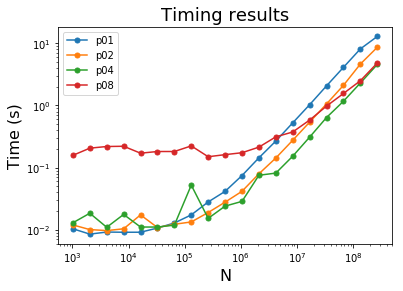

In [17]:
df_timing = panel.minor_xs('t') 
cols = ['N',*df_timing.columns]


df_timing['N'] = panel['p01']['N'].astype('int')
df_timing = df_timing[cols]
df_timing.plot(x='N',logx=True,logy=True,style='.-',markersize=10)

title("Timing results",fontsize=18);
xlabel("N",fontsize=16)
ylabel("Time (s)",fontsize=16)

<hr/>

## Strong scaling

If an algorithm scales well, we expect that adding more processors to a problem of fixed size should speed up the calculation.  If a code were "embarrassingly parallel", we expect two processors to take half as much time as one processor, 4 processors to take a quarter of the time, and so on.  We call this type of scaling "strong" scaling.  

For strong scaling, we compare timings for a fixed value of $N$.   We will choose one of the larger values to see better results.

In [19]:
idx = 18    # Choose N corresponding to index=18
N = int(panel['p01']['N'][idx])

procs = array([1,2,4,8])

df_strong = panel.major_xs(idx).transpose()    
df_strong['p'] = procs
df_strong[['p','soln','err','t']].style.set_caption("N = {:d}".format(N))

Plot the strong scaling results and show the best-fit line to get an estimate of the speed-up.  

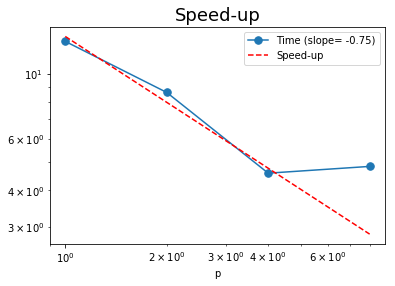

In [20]:
df_strong.plot(x='p',y='t',logx=True,logy=True,style='.-',markersize=15)

# Plot best-fit speed-up line
t_strong = array(df_strong['t'])
c = polyfit(log(procs[:-1]),log(t_strong[:-1]),1)
loglog(procs,exp(polyval(c,log(procs))),'r--')

legend(['Time (slope={:6.2f})'.format(c[0]),'Speed-up'])
title('Strong Scaling',fontsize=18);

## Weak scaling

If an algorithm scales well, we expect to be able to solve bigger problems by adding more processors.  For example, if we double the size of the problem, and double the number of processors, we expect the code to take the same time as the original problem.  This sort of scaling is called "weak scaling".  

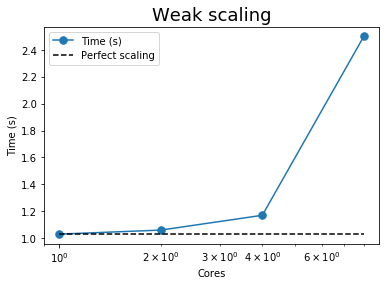

In [21]:
figure()
clf()
df_weak = panel.minor_xs('t')
idx = 14     # Start with 'N' index;  shift by one as we increase the processor count

t_weak = array([df_weak[c][14+i] for i,c in enumerate(df_weak.columns)])

semilogx(procs,t_weak,'.-',markersize=15)
semilogx(procs,[t_weak[0]]*4,'k--')
title('Weak scaling', fontsize=18)
xlabel('Cores')
ylabel("Time (s)")
legend(['Time (s)','Perfect scaling'])

## Efficiency

When we add more processors, we expect some overhead associated with more communication.  This is captured somewhat in the weak scaling results, but what is not shown is how quickly the efficiency drops off.  

Efficiency plots can often highlight poor scaling reslts that are not obvious from strong scaling results.

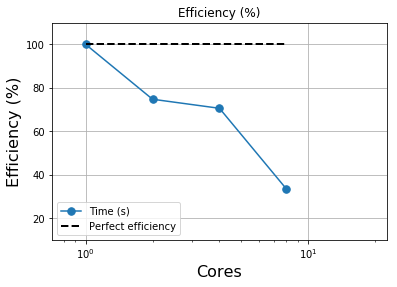

In [22]:
figure()
clf()

# Efficiency
E = t_strong[0]/(procs*t_strong)*100

semilogx(procs,E,'.-',markersize=15)
semilogx(procs,[100]*4,'k--',linewidth=2)

xlabel('Cores',fontsize=16)
ylabel('Efficiency (%)',fontsize=16)
title("Efficiency (%)");
legend(['Time (s)', 'Perfect efficiency'])
xlim([1/sqrt(2), 2**4.5])
ylim([10,110])
grid()